Notebook used in order to build subdataset corresponding to a given region of the brain.
Implemented conditions are
- "left-back"
- "right-back"
- "left-front"
- "right-front"


In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np 
import csv 
import pandas as pd
from pathlib import Path
from omegaconf import OmegaConf

from pytorch_lightning import Trainer
import pytorch_lightning as pl
from datetime import datetime
import os
import pandas as pd
import einops
import torch

from contrib.eeg.models_directinv import HeckerLSTM, HeckerLSTMpl
from contrib.eeg.models import CosineReshape, Cosine 
from contrib.eeg.data import EsiDatamodule, EsiDataset

from contrib.eeg.utils_eeg import plot_source_estimate, plot_src_from_imgs

from contrib.eeg.utils_eeg import load_fwd, load_mne_info
import json
import hydra

In [3]:
pl.seed_everything(333)

Global seed set to 333


333

## Load data

In [7]:
## Give the configuration file of the dataset to load: 
# datamodule_config_path = Path(
#     "config", "dataset", "ses_125ms_morph_test.yaml"
# )
# datamodule_config_path = Path(
#     "config", "dataset", "ses_125ms_morph_spl_spl.yaml"
# )
# datamodule_config_path = Path(
#     "config", "dataset", "test_ses_sereega_fsav994_125ms.yaml"
# )
datamodule_config_path = Path(
    "config", "dataset", "base_test_dataset.yaml"
)

In [8]:
home = os.path.expanduser("~")
datafolder = Path(home, "Documents/Data/simulation")

In [9]:
data_conf = OmegaConf.load(datamodule_config_path)
config_file = Path(
                datafolder, 
                data_conf.subject_name, data_conf.orientation, data_conf.electrode_montage, data_conf.source_sampling, "simu",
                data_conf.simu_name, f"{data_conf.simu_name}{data_conf.source_sampling}_config.json"
)        
data_conf.update({'config_file': config_file})

datamodule_conf = {
    "dataset_kw": 
    {
        "datafolder":datafolder, 
        "simu_name": data_conf.simu_name,
        "subject_name": data_conf.subject_name,
        "source_sampling": data_conf.source_sampling,
        "electrode_montage": data_conf.electrode_montage,
        "orientation": data_conf.orientation,
        "to_load": data_conf.to_load,
        "config_file": data_conf.config_file,
        "snr_db": 5,
        "noise_type": {"white":1.},
        "scaler_type": 'raw', #'linear_bis',
        "replace_root": True
    },
    "subset_name": "none",
    "dl_kw":{
        "batch_size": 16
    }
}
head_model_dict = {
    'subject_name': data_conf.subject_name,
    'orientation': data_conf.orientation,
    'electrode_montage': data_conf.electrode_montage,
    'source_sampling': data_conf.source_sampling,
}

In [10]:
dm = EsiDatamodule(**datamodule_conf)

In [11]:
fwd = load_fwd( datafolder=datafolder, head_model_dict=head_model_dict, fwd_name=f"fwd_{head_model_dict['source_sampling']}-fwd.fif", scaler_type=None )


Reading forward solution from /home/reynaudsarah/Documents/Data/simulation/fsaverage/constrained/standard_1020/ico3/model/fwd_ico3-fwd.fif...
    Reading a source space...
    [done]
    Reading a source space...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read EEG forward solution (1284 sources, 90 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame


In [12]:
from scipy.io import savemat

In [13]:
head_model_folder = Path(
                datafolder, 
                data_conf.subject_name, data_conf.orientation, data_conf.electrode_montage, data_conf.source_sampling, "model",
)        

In [14]:
# L = fwd['sol']['data']
# savemat(Path( head_model_folder, f"LF_{data_conf.source_sampling}.mat"), {"G": L} )

In [15]:
dm.setup('test')
# train_dl = dm.val_dataloader()
train_dl = dm.test_dataloader()
batch = next(iter(train_dl))

fwd = load_fwd( datafolder= datafolder, head_model_dict=head_model_dict, fwd_name=f"fwd_{head_model_dict['source_sampling']}-fwd.fif", scaler_type=None )
mne_info = load_mne_info( electrode_montage = data_conf['electrode_montage'], sampling_freq=512 )

leadfield = torch.from_numpy(fwd['sol']['data']).float()

n_electrodes = leadfield.shape[0]
n_sources = leadfield.shape[1]
n_times = batch.input.shape[-1]


--- only 1000 available ---
Reading forward solution from /home/reynaudsarah/Documents/Data/simulation/fsaverage/constrained/standard_1020/ico3/model/fwd_ico3-fwd.fif...
    Reading a source space...
    [done]
    Reading a source space...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read EEG forward solution (1284 sources, 90 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame


In [16]:
def replace_root_fn( simu_path, simu_name, string): 
        """ 
        replace "root" of file name (handle differences in simulations)
        """
        split = string.split(simu_name)
        mod_string = Path( 
            simu_path, simu_name, *split[1].split('/') 
            )
        return mod_string

def get_idx_condition(spos, condi="left-back"):
    # spos = fwd['source_rr']
    px = spos[:,0]
    py = spos[:,1]
    pz = spos[:,2]

    px0 = px.mean() 
    py0= py.mean() 
    pz0 = pz.mean()
    if condi=="left-back":
        x_cond = px < px0 
        y_cond = py < py0 
        all_cond = np.logical_and(x_cond, y_cond)
        selected_pos = spos[all_cond,:]
        index_cond = np.where(all_cond)[0]
    return index_cond

def get_subdataset(condi, datafolder, head_model, dataset_kw, spos, **kwargs): 
    # datafolder = cfg.datafolder
    ## build path to simulation ##
    simu_path = Path(  
        datafolder, head_model.subject_name, head_model.orientation, head_model.electrode_montage , head_model.source_sampling, "simu"
            )
    config_file = Path(
        dataset_kw['datafolder'], 
        dataset_kw['subject_name'], dataset_kw['orientation'], dataset_kw['electrode_montage'], dataset_kw['source_sampling'], "simu",
        dataset_kw['simu_name'], f"{dataset_kw['simu_name']}{dataset_kw['source_sampling']}_config.json"
            )
    with open(config_file) as f : 
        config_dict = json.load(f)

    info_file = Path( simu_path, dataset_kw.simu_name ,f"{dataset_kw.simu_name}{head_model.source_sampling}_match_json_file.json" )
    # load info to match the files
    with open(info_file) as f : 
        match_info_dict = json.load(f)
    data_ids = np.array( 
        list( match_info_dict.keys() )
    )
    index_cond = get_idx_condition(condi, spos)

    cond_id = []
    for id in data_ids : 
        md_json_file_name = replace_root_fn( 
            simu_path, 
            dataset_kw.simu_name,
            match_info_dict[id]['md_json_file_name']
            )
        with open( Path(datafolder, md_json_file_name) ) as f : 
            md = json.load(f)


        seed = md['seeds']
        if type(seed) != list: 
            seed = [seed]

        if seed in index_cond : 
            cond_id.append(id)
    
    where_to_save = Path( simu_path, dataset_kw.simu_name, f"{condi}.txt")
    with open(where_to_save, 'w') as f:
        for line in cond_id:
            f.write(f"{line}\n")
    
    return cond_id

## import ids of the dataset and information about the simulations
(seed)

In [17]:
# datafolder = data_conf['datafolder']
## build path to simulation ##
simu_path = Path(  
    datafolder, head_model_dict['subject_name'], head_model_dict['orientation'], head_model_dict['electrode_montage'] , head_model_dict['source_sampling'], "simu"
        )
print(simu_path)

config_file = Path(
    datamodule_conf['dataset_kw']['datafolder'], 
    datamodule_conf['dataset_kw']['subject_name'], datamodule_conf['dataset_kw']['orientation'], datamodule_conf['dataset_kw']['electrode_montage'], datamodule_conf['dataset_kw']['source_sampling'], "simu",
    datamodule_conf['dataset_kw']['simu_name'], f"{datamodule_conf['dataset_kw']['simu_name']}{datamodule_conf['dataset_kw']['source_sampling']}_config.json"
            )
with open(config_file) as f : 
    config_dict = json.load(f)

info_file = Path( simu_path, datamodule_conf['dataset_kw']['simu_name'] ,f"{datamodule_conf['dataset_kw']['simu_name']}{head_model_dict['source_sampling']}_match_json_file.json" )
# load info to match the files
with open(info_file) as f : 
    match_info_dict = json.load(f)
data_ids = np.array( 
    list( match_info_dict.keys() )
)

/home/reynaudsarah/Documents/Data/simulation/fsaverage/constrained/standard_1020/ico3/simu


## create condition

Based on source positions

In [18]:
spos = fwd['source_rr']
px = spos[:,0]
py = spos[:,1]
pz = spos[:,2]

px0 = px.mean() 
py0= py.mean() 
pz0 = pz.mean()

condi = "right_back"
## left-back
if condi == "left_back": 
    x_cond = px < px0 
    y_cond = py < py0 

## right back
elif condi == "right_back":
    x_cond = px > px0
    y_cond = py < py0 

## left-front
elif condi == "left_front":
    x_cond = px < px0
    y_cond = py > py0

##right-front
else : 
    x_cond = px > px0
    y_cond = py > py0

all_cond = np.logical_and(x_cond, y_cond)
selected_pos = spos[all_cond,:]
index_cond = np.where(all_cond)[0]

In [19]:
index_cond

array([ 146,  593,  595,  634,  643,  647,  648,  649,  652,  653,  657,
        659,  660,  662,  670,  671,  672,  673,  674,  675,  676,  677,
        681,  682,  683,  690,  692,  706,  707,  708,  709,  710,  711,
        712,  713,  714,  715,  717,  718,  725,  726,  727,  728,  729,
        730,  731,  732,  733,  739,  740,  741,  743,  744,  745,  746,
        750,  765,  766,  769,  770,  771,  772,  773,  774,  775,  776,
        777,  778,  779,  780,  781,  782,  783,  784,  785,  787,  788,
        793,  794,  795,  796,  797,  798,  799,  800,  801,  826,  827,
        828,  829,  830,  831,  832,  833,  834,  835,  845,  846,  847,
        848,  849,  850,  851,  852,  853,  862,  863,  864,  869,  870,
        871,  872,  873,  874,  875,  879,  880,  881,  882,  912,  919,
        920,  921,  923,  925,  926,  927,  928,  929,  930,  931,  932,
        933,  934,  935,  936,  937,  938,  939,  940,  941,  942,  943,
        944,  945,  946,  947,  948,  949,  950,  9

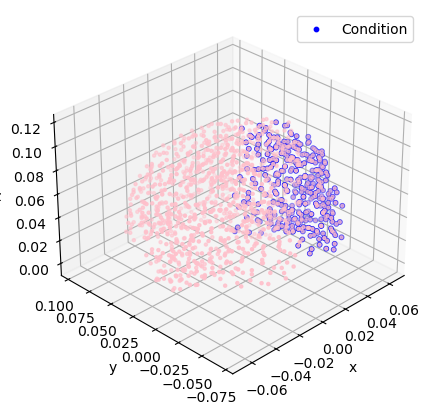

In [21]:
## Check the sources corresponding to the condition:
fig = plt.figure( figsize=(15, 5) ) 
ax = fig.add_subplot(1, 1, 1, projection="3d")
ax.scatter( spos[:,0], spos[:,1], spos[:,2] , c="pink", s=5)
ax.scatter( selected_pos[:,0], selected_pos[:,1], selected_pos[:,2], c="b", s=10, label="Condition" )
plt.legend()
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.view_init(azim=225)

Select only the data for which the seed is in the given condition

In [24]:
cond_id = []
for id in data_ids : 
    md_json_file_name = replace_root_fn( 
        simu_path, 
        datamodule_conf['dataset_kw']['simu_name'],
        match_info_dict[id]['md_json_file_name']
        )
    with open( Path(datafolder, md_json_file_name) ) as f : 
        md = json.load(f)


    seed = md['seeds']
    if type(seed) != list: 
        seed = [seed]

    if seed in index_cond : 
        cond_id.append(id)


Write in file

In [25]:
area_condi = condi
where_to_save = Path( simu_path, datamodule_conf['dataset_kw']['simu_name'], f"{area_condi}.txt")
print(f"Subset information saved in {where_to_save}")
with open(where_to_save, 'w') as f:
    for line in cond_id:
        f.write(f"{line}\n")

Subset information saved in /home/reynaudsarah/Documents/Data/simulation/fsaverage/constrained/standard_1020/ico3/simu/ses_125ms_test/right_back.txt


In [ ]:
# check how to load
# The file gives the list of id of data which corresponds to the condition.
with open(where_to_save, 'r') as file:
    lines = [line.rstrip() for line in file]
lines[0]

'id_12'

___